In [1]:
import os
import random
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

sns.set_style('ticks')
from pathlib import Path
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split         # Split data into train and test set
from sklearn.metrics import classification_report            # Summary of classifier performance

from utils import get_df, evaluate_classifier, numpy_confusion_matrix_to_pycm, save_confusion_matrix_fig 

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Spring barley',
    'Vinterbyg': 'Winter barley',
    'Vårhvede': 'Spring wheat',
    'Vinterhvede': 'Winter wheat',
    'Vinterrug': 'Winter rye',
    'Vårhavre': 'Spring oat',
    'Silomajs': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Permanent græs, normalt udbytte': 'Permanent grass',
    'Pil': 'Willow',
    'Skovdrift, alm.': 'Forest'
}

# Set global seed for random generators
RANDOM_SEED = 42

# Seed the random generators
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [2]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc')
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 52769, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 67365067 67365062
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 183 ms


In [3]:
ds.close()

time: 18.7 ms


In [4]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 8.96 s


In [5]:
# Create the df format to be used by scikit-learn
for i, polarization in enumerate(['VV', 'VH', 'VV-VH']):
    df_polarization = get_df(polygons_year=2019, 
                             satellite_dates=slice('2018-01-01', '2019-12-31'), 
                             fields='all', 
                             satellite='all', 
                             polarization=polarization,
                             netcdf_path=netcdf_path)
    
    # Extract a mapping of field_ids to crop type
    if i == 0:
        df_sklearn = df_polarization[['field_id', 'afgkode', 'afgroede']]
    
    # Pivot the df (https://stackoverflow.com/a/37790707/12045808)
    df_polarization = df_polarization.pivot(index='field_id', columns='date', values='stats_mean')
    
    # Add polarization to column names
    df_polarization.columns = [str(col)[:10]+f'_{polarization}' for col in df_polarization.columns]  
    
    # Merge the polarization dataframes into one dataframe
    df_polarization = df_polarization.reset_index()  # Creates new indices and a 'field_id' column (field id was used as indices before)
    df_sklearn = pd.merge(df_sklearn, df_polarization, on='field_id') 
        
# Drop fields having nan values
df_sklearn = df_sklearn.dropna()

# The merge operation for some reason made duplicates (there was a bug reported on this earlier), so drop duplicates and re-index the df
df_sklearn = df_sklearn.drop_duplicates().reset_index(drop=True)

time: 28.3 s


In [6]:
df_sklearn_remapped = df_sklearn.copy()

df_sklearn_remapped.insert(3, 'Crop type', '')
df_sklearn_remapped.insert(4, 'Label ID', 0)
mapping_dict = {}
class_names = [] 
i = 0
for key, value in mapping_dict_crop_types.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
    if value not in class_names:
        class_names.append(value)
        mapping_dict[value] = i
        i += 1
    
for key, value in mapping_dict.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
print(f"Crop types: {class_names}")

Crop types: ['Potato', 'Spring barley', 'Winter barley', 'Spring wheat', 'Winter wheat', 'Winter rye', 'Spring oat', 'Maize', 'Rapeseed', 'Permanent grass', 'Willow', 'Forest']
time: 226 ms


In [7]:
array = df_sklearn_remapped.values

# Define the independent variables as features.
X = np.float32(array[:,5:])  # The features 

# Define the target (dependent) variable as labels.
y = np.int8(array[:,4])  # The column 'afgkode'

# Create a train/test split using 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=RANDOM_SEED)

print(f"Train samples:      {len(y_train)}")
print(f"Test samples:       {len(y_test)}")
print(f"Number of features: {len(X[0,:])}")

Train samples:      31033
Test samples:       13300
Number of features: 231
time: 945 ms


-------------------------------------------------------------------------------
Evaluating classifier: Nearest Neighbors
Training time: 301.0002 s
Prediction time: 195.1238 s

Report:

Train accuracy: 0.926
Test accuracy: 0.908

                  precision    recall  f1-score   support

         Potato       0.98      0.96      0.97      2251
  Spring barley       0.81      0.86      0.84      1187
  Winter barley       0.96      0.95      0.96      1311
   Spring wheat       0.68      0.38      0.49       482
   Winter wheat       0.89      0.94      0.91      1114
     Winter rye       0.93      0.94      0.94      1290
     Spring oat       0.87      0.81      0.84      1340
          Maize       0.90      0.97      0.94      1430
       Rapeseed       1.00      0.99      1.00      1121
Permanent grass       0.84      0.93      0.88      1135
         Willow       0.85      0.85      0.85       251
         Forest       0.86      0.87      0.87       388

       accuracy            

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training time: 26.8765 s
Prediction time: 0.0068 s

Report:

Train accuracy: 0.929
Test accuracy: 0.9226

                  precision    recall  f1-score   support

         Potato       0.99      0.97      0.98      2251
  Spring barley       0.89      0.86      0.87      1187
  Winter barley       0.97      0.97      0.97      1311
   Spring wheat       0.59      0.68      0.63       482
   Winter wheat       0.91      0.95      0.93      1114
     Winter rye       0.96      0.93      0.95      1290
     Spring oat       0.90      0.83      0.87      1340
          Maize       0.97      0.97      0.97      1430
       Rapeseed       1.00      0.99      1.00      1121
Permanent grass       0.89      0.90      0.89      1135
         Willow       0.71      0.91      0.80       251
         Forest       0.87      0.87      0.87       388

       accuracy                           0.92     13300
      macro avg       0.89      0.90      0.89     13300
   weighted avg       0.93      0.92

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Training time: 1064.2679 s
Prediction time: 0.0289 s

Report:

Train accuracy: 0.9501
Test accuracy: 0.9359

                  precision    recall  f1-score   support

         Potato       0.98      0.98      0.98      2251
  Spring barley       0.88      0.92      0.90      1187
  Winter barley       0.97      0.98      0.97      1311
   Spring wheat       0.79      0.58      0.67       482
   Winter wheat       0.90      0.97      0.94      1114
     Winter rye       0.96      0.95      0.95      1290
     Spring oat       0.89      0.89      0.89      1340
          Maize       0.96      0.98      0.97      1430
       Rapeseed       1.00      0.99      0.99      1121
Permanent grass       0.90      0.92      0.91      1135
         Willow       0.87      0.87      0.87       251
         Forest       0.92      0.85      0.88       388

       accuracy                           0.94     13300
      macro avg       0.92      0.91      0.91     13300
   weighted avg       0.93      0

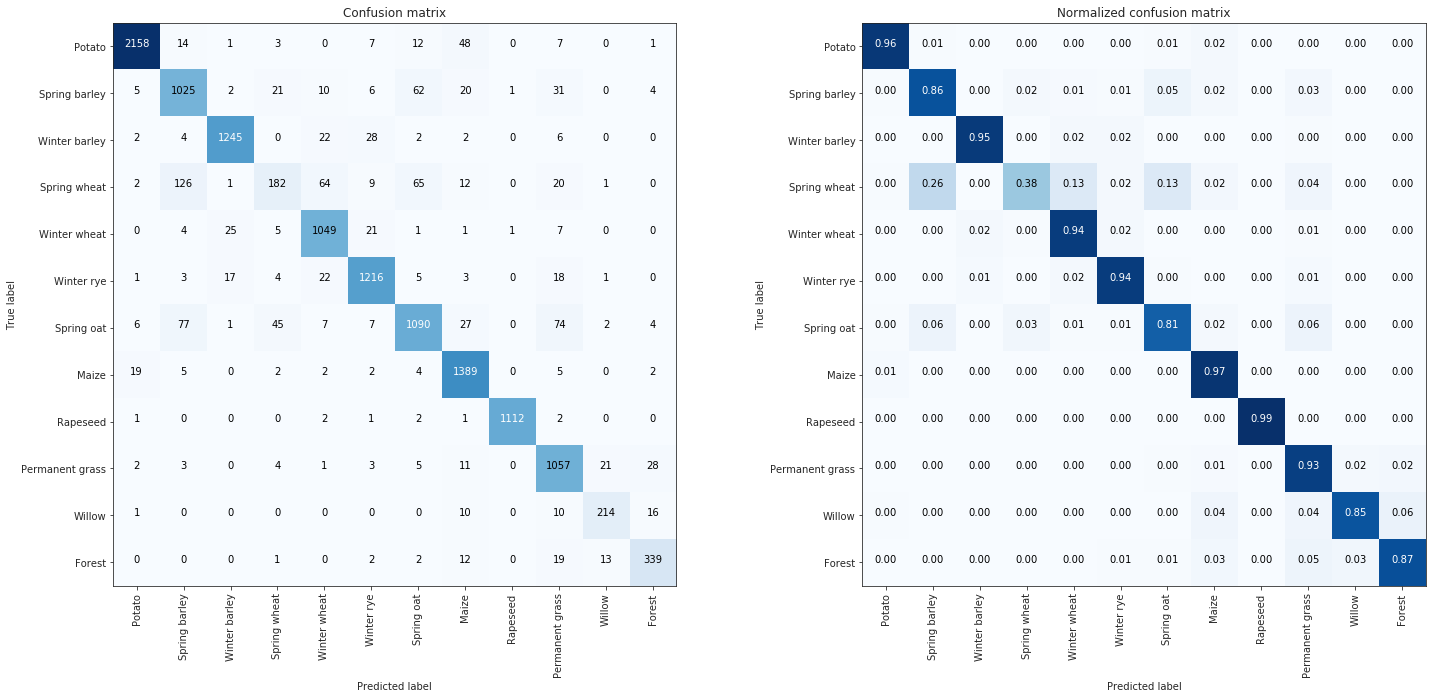

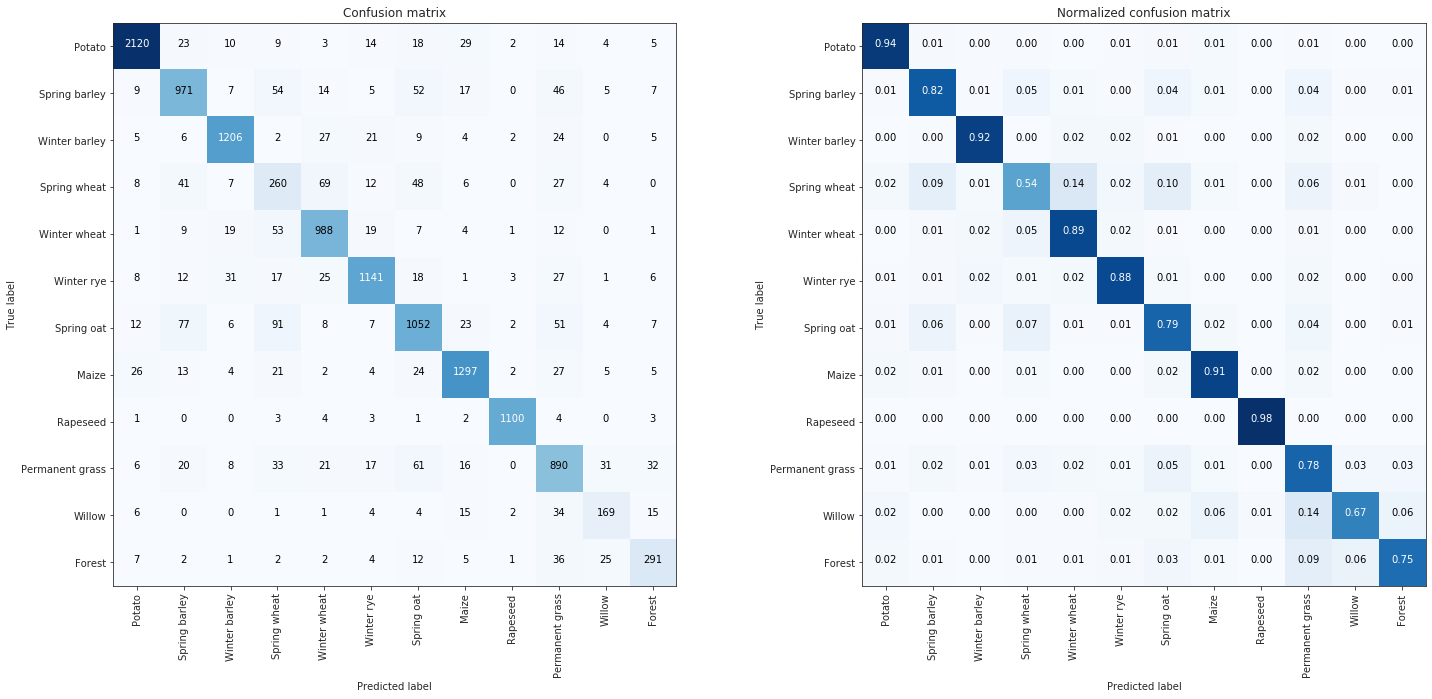

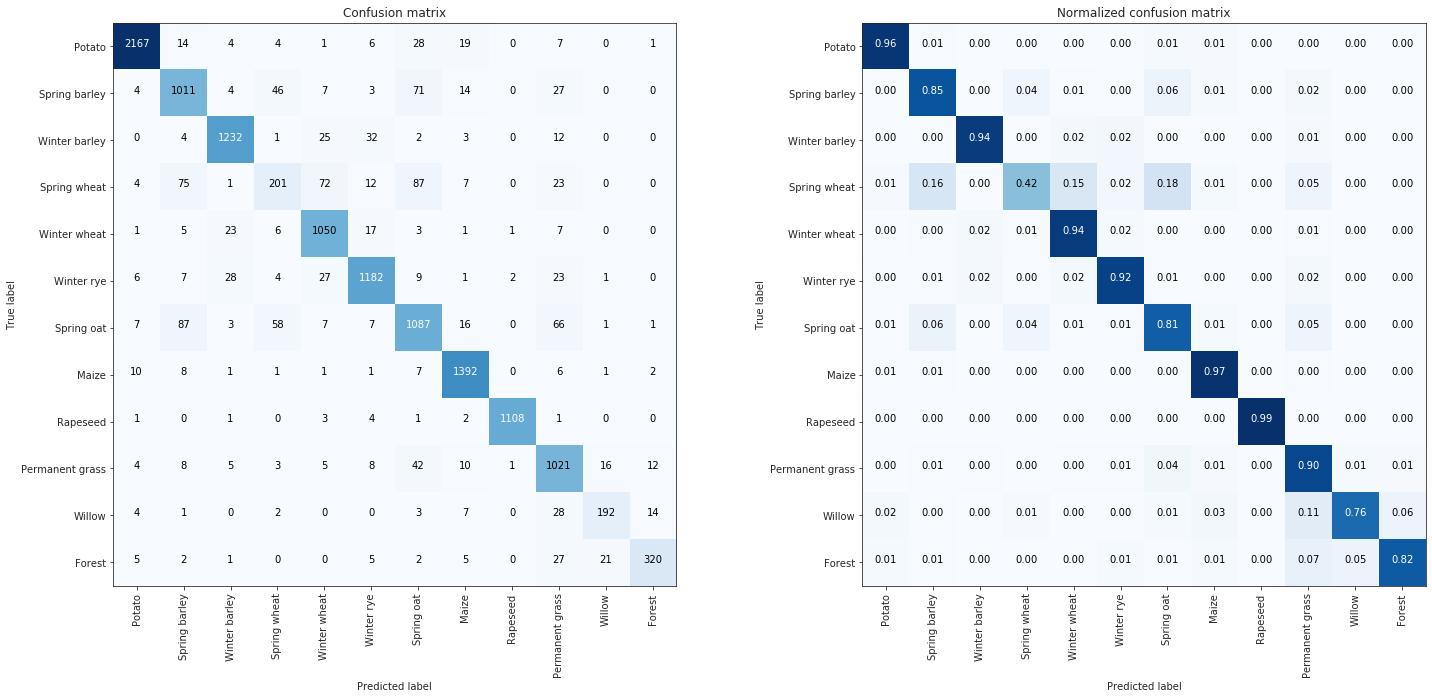

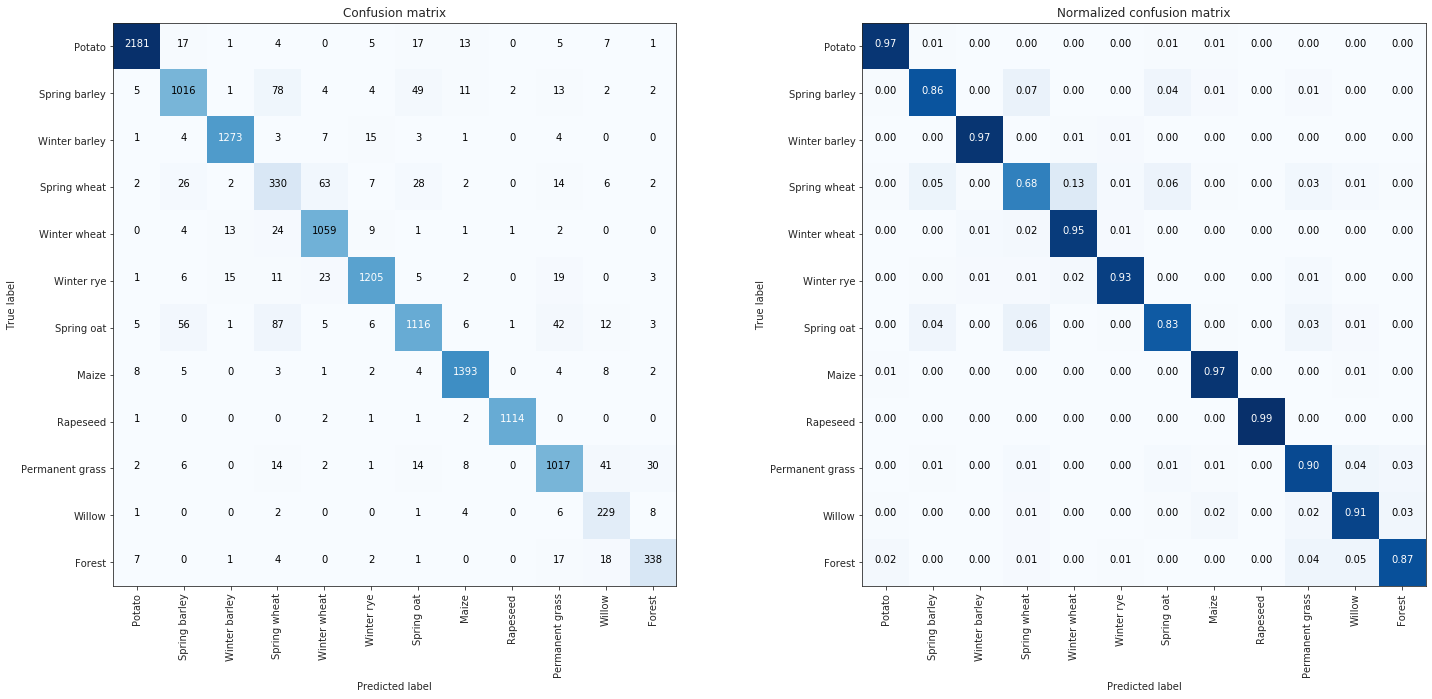

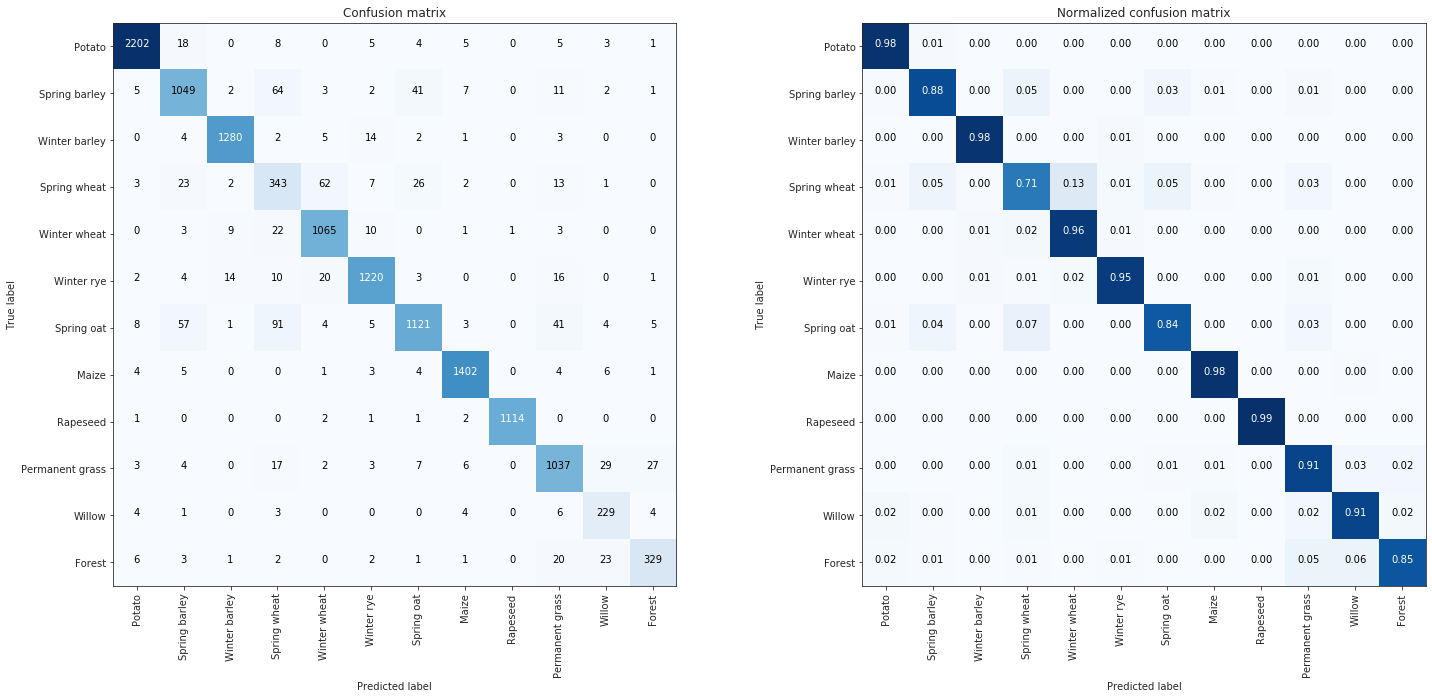

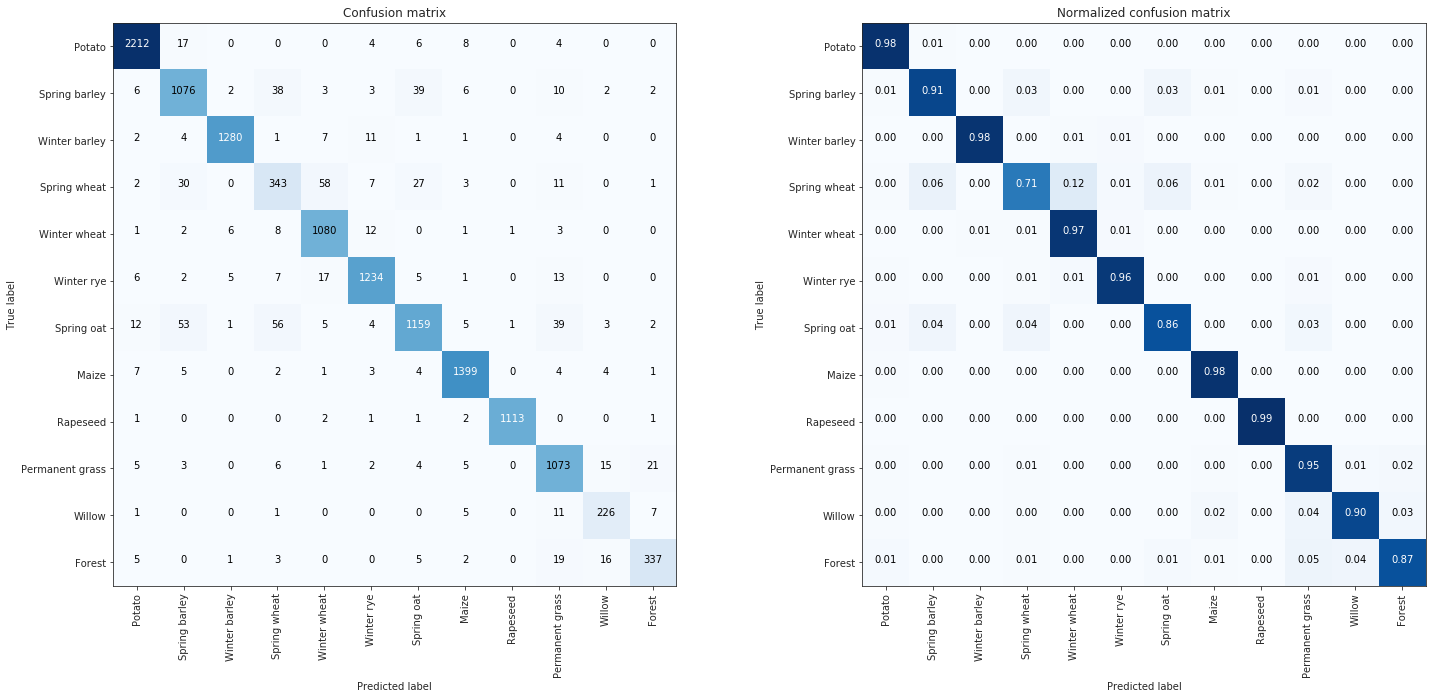

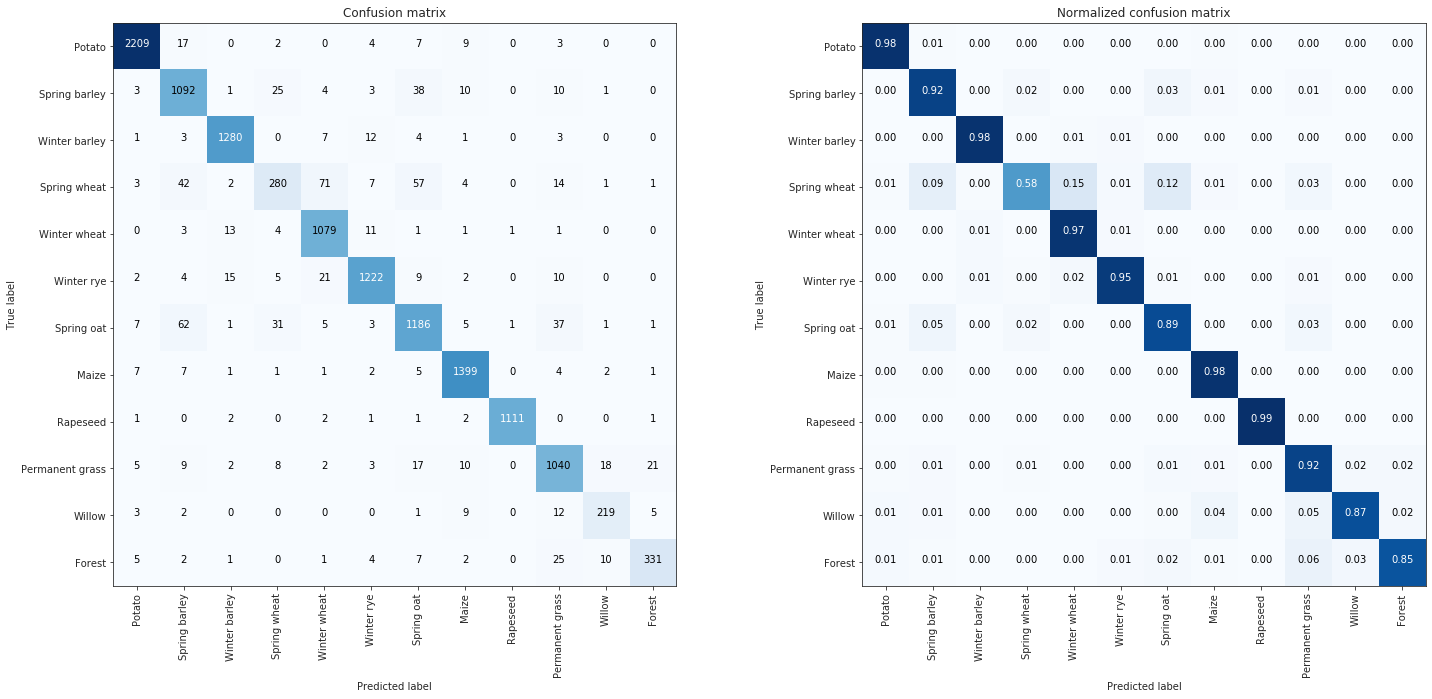

time: 1h 8min 1s


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression          
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# From https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
# Note: GaussianClassifier does not work (maybe requires too much training - kernel restarts in jupyter)
N_JOBS=24
classifiers = { 
    'Nearest Neighbors': GridSearchCV(KNeighborsClassifier(), 
                                      param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8]}, 
                                      refit=True, cv=5, n_jobs=N_JOBS),
    'Decision Tree': GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_SEED, class_weight='balanced'), 
                                  param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16]}, 
                                  refit=True, cv=5, n_jobs=N_JOBS),
    'Random Forest': GridSearchCV(RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced'), 
                                  param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16], 
                                              'n_estimators': [6, 8, 10, 12, 14], 
                                              'max_features': [1, 2, 3]},
                                  refit=True, cv=5, n_jobs=N_JOBS),
    'Logistic Regression': GridSearchCV(LogisticRegression(random_state=RANDOM_SEED, class_weight='balanced'),
                                        param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2],
                                                    'penalty': ['none', 'l2']},
                                        refit=True, cv=5, n_jobs=N_JOBS),
    'Linear SVM': GridSearchCV(SVC(kernel='linear', random_state=RANDOM_SEED, class_weight='balanced'),
                               #param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]},
                               param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]},
                               refit=True, cv=5, n_jobs=N_JOBS),
    'RBF SVM': GridSearchCV(SVC(kernel='rbf', random_state=RANDOM_SEED, class_weight='balanced'),
                            #param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]},
                            param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]},
                            refit=True, cv=5, n_jobs=N_JOBS),
    'Neural Network': GridSearchCV(MLPClassifier(max_iter=1000, random_state=RANDOM_SEED),
                                   param_grid={'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
                                               'hidden_layer_sizes': [(50,50,50), (100, 100, 100), (100,)],
                                               'activation': ['tanh', 'relu'],
                                               'learning_rate': ['constant','adaptive']},
                                   refit=True, cv=5, n_jobs=N_JOBS)
    }

clf_trained_dict = {}
report_dict = {}
cm_dict = {}

# TODO: Also calculate uncertainties - ie. use multiple random seeds.
#       Create df (with cols [Clf_name, Random_seed, Acc., Prec., Recall, F1-score]) and loop over random seeds
#       See following on how to format pandas dataframe to get the uncertainties into the df
#       https://stackoverflow.com/questions/46584736/pandas-change-between-mean-std-and-plus-minus-notations

for name, clf in classifiers.items():
    # Evaluate classifier
    print("-------------------------------------------------------------------------------")
    print(f"Evaluating classifier: {name}")
    clf_trained, _, _, results_report, cnf_matrix = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)      
    print(f"The best parameters are {clf_trained.best_params_} with a score of {clf_trained.best_score_:2f}")

    # Save results in dicts
    clf_trained_dict[name] = clf_trained
    report_dict[name] = results_report
    cm_dict[name] = cnf_matrix

In [12]:
# Create df with results from classifiers and create latex table with them
df_clf_results = pd.DataFrame(columns=['Name', 'Acc.', 'Prec.', 'Recall', 'F1-Score'])
for name, results_report in report_dict.items():
    df_results = pd.DataFrame(report_dict[name]).transpose()  
    prec = df_results.loc['weighted avg', 'precision']
    recall = df_results.loc['weighted avg', 'recall']
    f1 = df_results.loc['weighted avg', 'f1-score']
    acc = df_results.loc['accuracy', 'f1-score']
    
    # Insert row in df (https://stackoverflow.com/a/24284680/12045808)
    df_clf_results.loc[-1] = [name, acc, prec, recall, f1]
    df_clf_results.index = df_clf_results.index + 1  # shifting index
    df_clf_results = df_clf_results.sort_index()  # sorting by index
    
# Print df in latex format
pd.options.display.float_format = '{:.2f}'.format  # Show 2 decimals
print(df_clf_results.sort_index(ascending=False).to_latex(index=False))  

\begin{tabular}{lrrrr}
\toprule
                Name &  Acc. &  Prec. &  Recall &  F1-Score \\
\midrule
   Nearest Neighbors &  0.91 &   0.91 &    0.91 &      0.90 \\
       Decision Tree &  0.86 &   0.87 &    0.86 &      0.86 \\
       Random Forest &  0.90 &   0.90 &    0.90 &      0.90 \\
 Logistic Regression &  0.92 &   0.93 &    0.92 &      0.92 \\
          Linear SVM &  0.93 &   0.93 &    0.93 &      0.93 \\
             RBF SVM &  0.94 &   0.94 &    0.94 &      0.94 \\
      Neural Network &  0.94 &   0.93 &    0.94 &      0.93 \\
\bottomrule
\end{tabular}

time: 63.6 ms


In [10]:
# Show performance on different classes with best performing classifier
# Get classfication report as pandas df
df_results = pd.DataFrame(report_dict['RBF SVM']).transpose()  

# Round the values to 2 decimals
df_results = df_results.astype({'support': 'int32'}).round(2) 

# Remove samples from 'macro avg' and 'weighed avg'
df_results.loc[df_results.index == 'accuracy', 'precision'] = ''  
df_results.loc[df_results.index == 'accuracy', 'recall'] = ''  
df_results.loc[df_results.index == 'accuracy', 'support'] = df_results.loc[df_results.index == 'macro avg', 'support'].values

# Rename the support column to 'samples'
df_results = df_results.rename(columns={'precision': 'Prec.',
                                        'recall': 'Recall',
                                        'f1-score': 'F1-score',
                                        'support': 'Samples'},
                               index={'accuracy': 'Overall acc.',
                                      'macro avg': 'Macro avg.',
                                      'weighted avg': 'Weighted avg.'})


# Print df in latex format (I normally add a /midrule above 'Macro avg.' and delete 'Overall acc.')
pd.options.display.float_format = '{:.2f}'.format  # Show 2 decimals
print(df_results.to_latex(index=True))  

\begin{tabular}{lllrr}
\toprule
{} & Prec. & Recall &  F1-score &  Samples \\
\midrule
Potato          &  0.98 &   0.98 &      0.98 &     2251 \\
Spring barley   &  0.90 &   0.91 &      0.90 &     1187 \\
Winter barley   &  0.99 &   0.98 &      0.98 &     1311 \\
Spring wheat    &  0.74 &   0.71 &      0.72 &      482 \\
Winter wheat    &  0.92 &   0.97 &      0.94 &     1114 \\
Winter rye      &  0.96 &   0.96 &      0.96 &     1290 \\
Spring oat      &  0.93 &   0.86 &      0.89 &     1340 \\
Maize           &  0.97 &   0.98 &      0.98 &     1430 \\
Rapeseed        &  1.00 &   0.99 &      1.00 &     1121 \\
Permanent grass &  0.90 &   0.95 &      0.92 &     1135 \\
Willow          &  0.85 &   0.90 &      0.87 &      251 \\
Forest          &  0.91 &   0.87 &      0.89 &      388 \\
Overall acc.    &       &        &      0.94 &    13300 \\
Macro avg.      &  0.92 &   0.92 &      0.92 &    13300 \\
Weighted avg.   &  0.94 &   0.94 &      0.94 &    13300 \\
\bottomrule
\end{tabular}

t

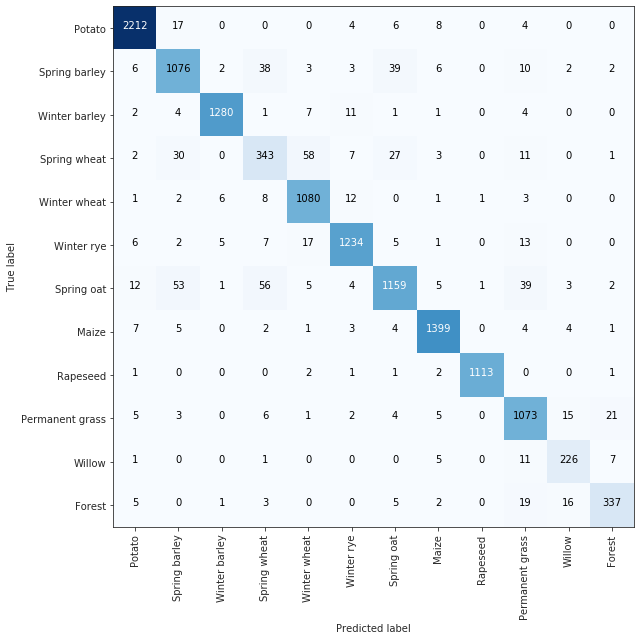

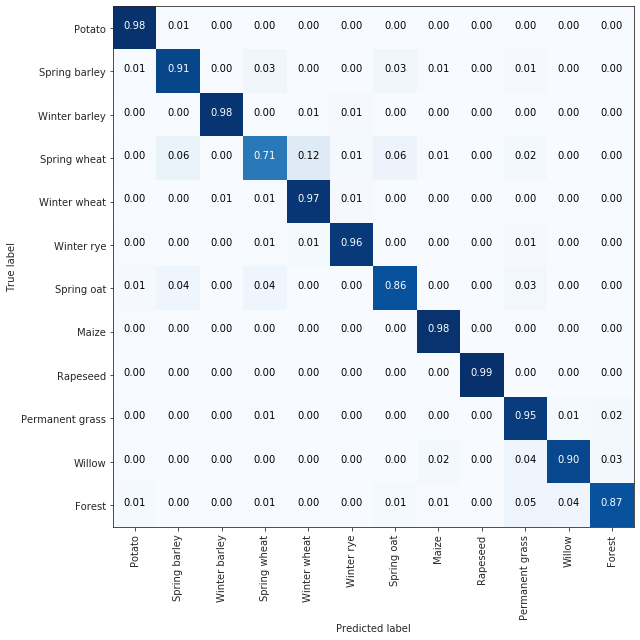

time: 1.55 s


In [11]:
# Save the confusion matrix figure you want
plot_name = 'RBF_SVM_conf_matrix'
plot_path = PROJ_PATH / 'reports' / 'figures' / 'conf_matrices' / plot_name
if not plot_path.parent.exists():
    plot_path.parent.mkdir()
    
save_confusion_matrix_fig(cm_dict['RBF SVM'], classes=class_names, save_path=plot_path)
save_confusion_matrix_fig(cm_dict['RBF SVM'], classes=class_names, save_path=plot_path, normalized=True)